# Introduction

**Since COVID-19 is the new puzzle all the world is trying to solve. We aim to make it easier for scientists to investigate and learn about the spreading virus to help fight it. **
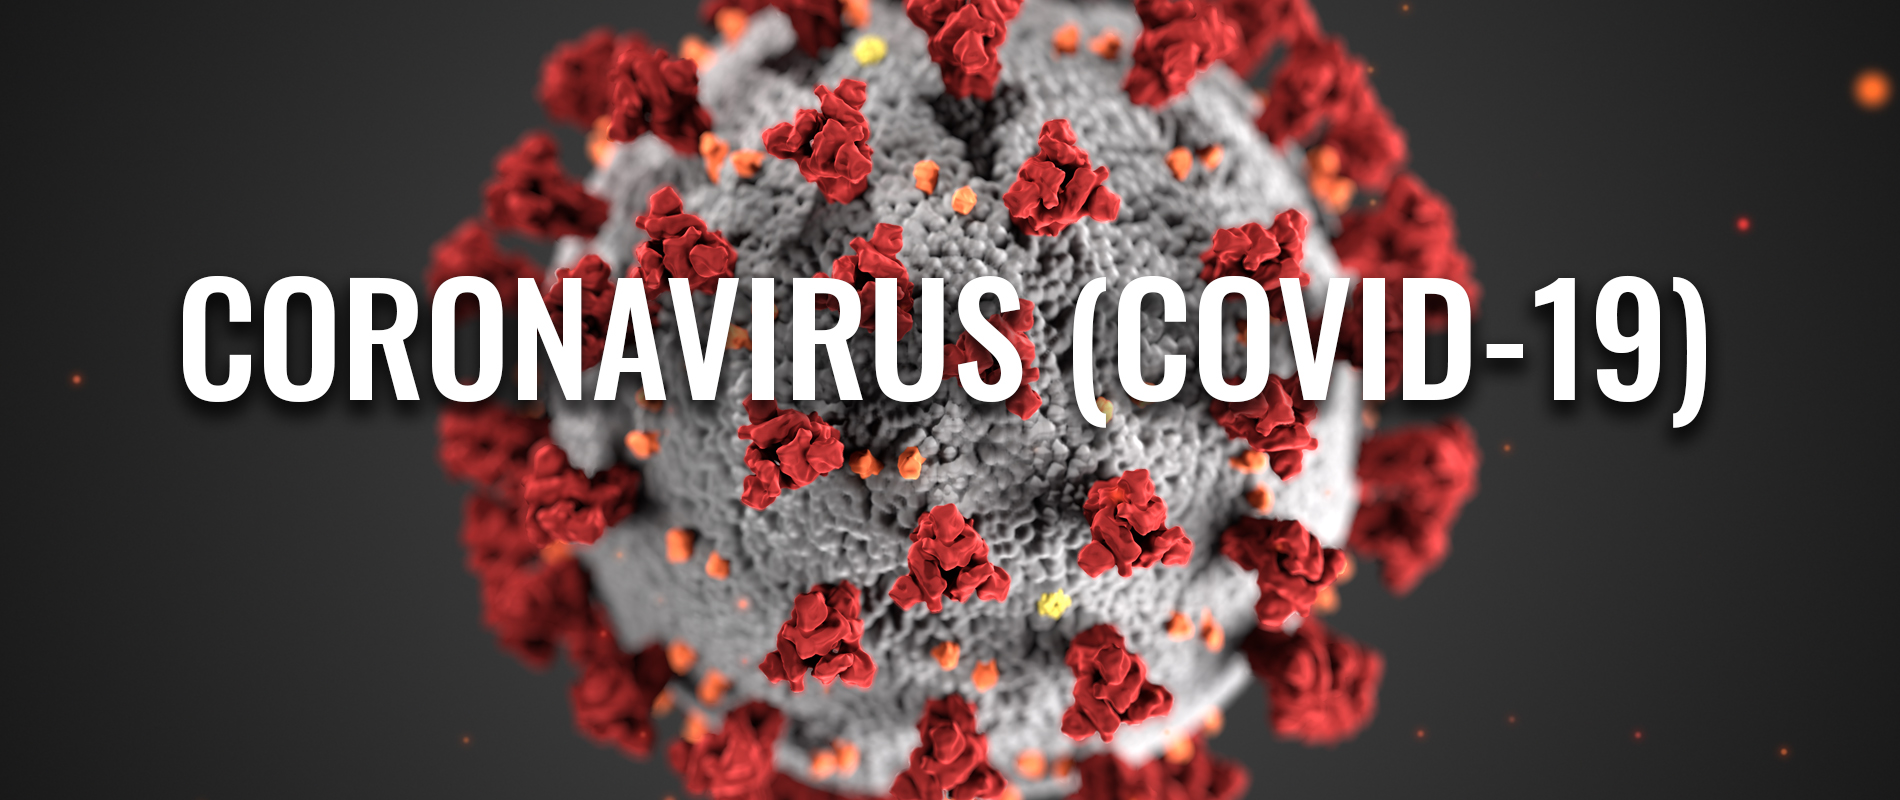

# Methodology

**In this notebook, we are trying to find *data on potential risks factors***


**We are using NLP (natural language processing) approaches to:**
* Find keywords on potential risk factors in the papers and analyze these findings.
* Get the highlights of each paper about potential risk factors and view them in an easy to make it easier to investigate those factors.

# Pros

* Getting results only related to new generation of coronavirus which is COVID-19.
* Easily manipulating/adding keywords that we are searching for.
* Visualizing what are the most topics mentioned in relation with COVID-19.
* Adding URL next to every highlight (if URL is available in dataset for the paper) for easy completion of reading when interested.

# Cons

* Getting faulty results pointing to COVID-19 symptoms/effect instead of risk factor.

# Let's Start!

# Imports

In [ ]:
#importing libraries needed
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import json
from IPython.display import Image
from IPython.core.display import HTML
import re
from re import finditer
import nltk
import spacy
from nltk.stem import PorterStemmer
from collections import defaultdict
import seaborn as sb 
import matplotlib.pyplot as plt

# Data Used

In [ ]:
# retrieving all files which contain articles we will process
files = []
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        if filename.endswith(".json"):
            files.append(os.path.join(dirname, filename))

files.sort()

In [ ]:
df=pd.read_csv('/kaggle/input/CORD-19-research-challenge/metadata.csv', usecols=['title','abstract','full_text_file','publish_time','url'])
df

# Identify sets of unigrams(1-gram) we are searching for.

1. Virus Unigrams
    * We need to find keywords that link to the virus (example: "COVID-19", "SARS-CoV-2", etc..)
    
    
2. Risk Factors Unigrams
    * To explore risk factor of lung diseases we can search for "smoke" and "pulmonary". 
    * To explore risk factor of co-infections and co-morbidities we can search for "diabetes" , "hypertension", "kidney", "pre-existing", "kidney", "renal", "immune", "deficiency", "chemotherapy", "cancer", "oncology", "malignant" and "cancer"
    * To explore risk factor of neonates and pregnant women we can search for "neonates", "pregnancy", "pregnant" and "neo-natal"
    * To explore risk socio-economic and behavioral factors we can search for "socio-economic", "behavior", "social" and "economic"
    

In [ ]:
word_stemmer = PorterStemmer()

# defining virus and risk factors keywords
targets = [set({"smoke", "pulmonary", "diabetes" , "hypertension", "kidney", "pre-existing", "kidney", "renal", "immune", "deficiency", "chemotherapy","oncology", "malignant", "cancer", "neonates", "pregnancy", "pregnant", "neo-natal" , "socio-economic", "behavior", "social","economic"}),
         set({"covid-19", "covid19", "sars-cov-2", "2019-ncov"})]

reverse_map = {}
# convert target terms into their stemmed versions for successfull matching
for i in range(0, len(targets)):
    newterms = set()
    for term in targets[i]:
        stemmedTerm = word_stemmer.stem(term)
        newterms.add(stemmedTerm)
        reverse_map[stemmedTerm] = term
    targets[i] = newterms

# displaying stemmed targets
for term in targets:
    print(term)

# Segmenting each paragraph

In [ ]:
# main method which will categorize each paragraph to a specific segment
def segment_paragraph(segment, paper_id=None, cnt=None):
    global targets
    
    sentence_tokenized = defaultdict(lambda: defaultdict(lambda: ""))
    sentence_full = defaultdict(lambda: defaultdict(lambda: ""))
    
    json_txt_full = nltk.sent_tokenize(segment)
    json_txt = [[word_stemmer.stem(y.lower()) for y in nltk.word_tokenize(x)] for x in json_txt_full]
    if not paper_id is None:
        sentence_tokenized[paper_id][cnt] = json_txt
        sentence_full[paper_id][cnt] = json_txt_full
    
    #the list of found words.
    keywords_found = []
    
    for i in range(0, len(json_txt)):
        
        # find target keywords in each sentence.
        matched = set()
        for j in range(0, len(json_txt[i])):
            word = json_txt[i][j]                    
            # check for match
            for k in range(0, len(targets)):
                if word in targets[k]:
                    matched.add(k)
                    # when k == 0 means it maches one of the risk factors keywords
                    if(k == 0):
                        keywords_count[word] += 1
                                   
        keywords_found.append(matched)
        
    #For each sentence, we check if all terms were located. 
    #If not, then we check if the missing terms were in either the preceding of following sentence.
    
    valid_sentence = None
    valid_tags = None
    tag_set = set()
    for i in range(0, len(keywords_found)):
        if len(keywords_found[i])==len(targets):
            valid_sentence = json_txt_full[i]
            valid_tags = json_txt[i]
            break
        
        # at least one target is missing. check the neighbors
        temp_set = keywords_found[i].copy()
        if i > 0:
            temp_set.update(keywords_found[i-1])
            if len(temp_set)==len(targets):
                valid_sentence = json_txt_full[i-1] + " " + json_txt_full[i]
                valid_tags = json_txt[i] + (json_txt[i-1])
                break
                
        temp_set = keywords_found[i].copy()
        if i < (len(keywords_found) - 1):
            temp_set.update(keywords_found[i+1])
            if len(temp_set)==len(targets):
                valid_sentence = json_txt_full[i] + " " + json_txt_full[i+1]
                valid_tags = json_txt[i] + (json_txt[i+1])
                break          
    
    if not valid_sentence:
        return False, "", set()
    
    # find the set of tags that were matched
    matched_set = set()
    vbase = valid_tags
    valid_tags = set(valid_tags)
    for i in range(0, len(targets)-1):
        matched_set = matched_set.union(targets[i])
    valid_tags = valid_tags.intersection(matched_set)
    
    return True, valid_sentence, valid_tags

# Now for each json file,we will send body text paragraph to segment_paragraph()

In [ ]:
def process_file(json_file):
        # check if there's a match.
        json_body = json_file["body_text"]
        temp = defaultdict(lambda x: "")
        
         # loop through each paragraph
        for cnt, x in enumerate(json_body):
            is_valid, valid_segment, valid_tags = segment_paragraph(x["text"], json_file["paper_id"], cnt)
            if is_valid:
                json_dict[json_file["paper_id"]].append({"text":x["text"], "tags":valid_tags, "segment":valid_segment, "paper_id":json_file["paper_id"], "title":json_file["metadata"]["title"]})
                print ("found match: {} : {} => {}".format(json_file["paper_id"], valid_segment, valid_tags))

# Send all json files from data acquired to process_article()

In [ ]:
# json_dict will hold the tokenized sentences for each paragraph in each document
json_dict = defaultdict(lambda:[])

#tracks count of each risk factor keyword found from targets
keywords_count = defaultdict(int)

#limit number of files processed
stop_counter = 0

for file in files:
    #remove this if condition to process all corpus papers
    if(stop_counter == 500):
        break
    process_file(json.load(open(file, "r")))
    stop_counter+=1

# Analysis from keywords count per corpus

## We want to use this analysis for two assumptions:
* To visualize most frequent mentioned topics(from their keywords) and that rises a possibility of its importance regarding COVID-19
* To visualize least frequent mentioned topics and that rises a possibility of the need to explore these topics more.

### Plotting keywords count across corpus

In [ ]:
#converting keywords dictionary to a dataframe to easily analyze it
keywords_df = pd.DataFrame(keywords_count.items(), columns=['Keyword', 'Total_Keyword_Count'])
keywords_df = keywords_df.set_index('Keyword')

#adding same context keywords together
keywords_df.loc['pregnant'] += keywords_df.loc['pregnanc']
keywords_df = keywords_df.drop(['pregnanc'])

#sorting dataframe to show most frequently mentioned keyword per corpus
keywords_df = keywords_df.sort_values(by=['Total_Keyword_Count'])

# Plotting keywords count across corpus
graph = keywords_df['Total_Keyword_Count'].plot(kind = 'barh', figsize = (10,6))
plt.xlabel('Total_Keyword_Count')
plt.ylabel('Keyword')
print(graph)

### Plotting frequency of each risk factor category which are divided into 4 categories
* Smoking and pre-existing pulmonary diseases
* Co-infections and co-morbidities
* Neonates and pregnant women
* Socio-economic and behavioral factors

In [ ]:
#creating a new column holding risk factor category for each row that we mentioned above
categories = []
for keyword in keywords_df.index:
    if(keyword == 'pulmonari' or keyword == 'smoke'):
        categories.append('Smoking and pre-existing pulmonary diseases')
    elif(keyword == 'pregnant' or keyword == 'neonat'):
        categories.append('Neonates and pregnant women')
    elif(keyword == 'behavior' or keyword == 'socio-econom' or keyword == 'social' or keyword == 'econom'):
        categories.append('Socio-economic and behavioral factors')
    else:
        categories.append('Co-infections and co-morbidities')
keywords_df.insert(1,"Risk_Factor_Category", categories, True) 
keywords_df = keywords_df.sort_values(by=['Total_Keyword_Count'] , ascending = False)

#plotting frequency of mentioning each category
group_df = keywords_df.groupby("Risk_Factor_Category",as_index=False)['Total_Keyword_Count'].sum()
print(group_df.index.values)
graph = group_df.plot(kind = 'bar')
plt.xlabel('Risk_Factor_Category')
plt.xticks(group_df.index,group_df['Risk_Factor_Category'].values)
plt.title('Frequency of mentioned topics',size = 20)
print(graph)

# Now better view on relative articles found 
* By highlighting virus and risk factors keywords
* Adding their URL beside each relative paragraph found

In [ ]:
#method which gets URL of each paper using its title
def get_URL(title):
    if( not df.loc[df['title'] == title]['url'].empty):
        return " "+df.loc[df['title'] == title]['url'].values[0]
    else:
        return ""

In [ ]:
topics = defaultdict(lambda: {"text":[], "title":[], "rawtag":""})

for paper_id, found_objs in json_dict.items():
    
    for ele in found_objs:
        
        # for each tag (usually only one) see which topic this falls under
        for tag in ele["tags"]:
            topics[reverse_map[tag]]["text"].append(ele["segment"])
            topics[reverse_map[tag]]["title"].append(ele["title"])
            topics[reverse_map[tag]]["rawtag"] = tag
            
htmls = defaultdict(lambda: "")
for topic_name in topics:
    htmlstr = "<div class='test_output'>"
    htmlstr += "<br /><div style='font-weight:bold;'>{}</div><br />".format(topic_name)
    htmlstr += "<div style='display:table;'>"
    
    for q, entry in enumerate(topics[topic_name]["text"]):
        splinter = nltk.word_tokenize(entry)
        
        for i in range(0, len(splinter)):
            if word_stemmer.stem(splinter[i])==topics[topic_name]["rawtag"]:
                splinter[i] = "<span style='background-color:#FFCC33;'>" + splinter[i] + "</span>"
            elif word_stemmer.stem(splinter[i]) in targets[-1]:
                splinter[i] = "<span style='background-color:#ADD8E6;'>" + splinter[i] + "</span>"
        
        if(get_URL(topics[topic_name]["title"][q]) != ""):
            formatted = " ".join(splinter) + "<u> <a href=" + get_URL(topics[topic_name]["title"][q]) +">" + "<span style='color:#0099cc;'> [" + topics[topic_name]["title"][q] + "] </span>" + "</a> </u>"
        else:
            formatted = " ".join(splinter) + "<span style='color:#0099cc;'> [" + topics[topic_name]["title"][q] + "] </span>"
            
        
        htmlstr += "<div style='display:table-row;'>"
        htmlstr += "<div style='display:table-cell;padding-right:15px;font-size:20px;'>•</div><div style='display:table-cell;'>" + formatted + "</div>"
        htmlstr += "</div>"
        
    htmlstr += "</div>"
    htmlstr += "</div>"
    htmls[topic_name] = htmlstr

# Highlights regarding potiential risk factors of smoking and pre-existing pulmonary disease
** Note: These are not the complete results as not all json files are sent to process_article() due to time constraints, but you can do it!**

In [ ]:
display(HTML(htmls["smoke"]))

In [ ]:
display(HTML(htmls["pulmonary"]))

# Highlights regarding potiential risk factors of co-infections and co-morbidities
** Note: These are not the complete results as not all json files are sent to process_article() due to time constraints, but you can do it!**

"diabetes" , "hypertension", "kidney", "pre-existing", "kidney", "renal", "immune", "deficiency", "chemotherapy", "cancer", "oncology", "malignant", "cancer", "neonates", "pregnancy", "pregnant", "neo-natal" , "socio-economic", "behavior", "social","economic"}),
         set({"covid-19", "covid19", "sars-cov-2", "2019-ncov"})]

In [ ]:
display(HTML(htmls["kidney"]))

In [ ]:
display(HTML(htmls["pre-existing"]))

In [ ]:
display(HTML(htmls["renal"]))

In [ ]:
display(HTML(htmls["immune"]))

In [ ]:
display(HTML(htmls["deficiency"]))

In [ ]:
display(HTML(htmls["chemotherapy"]))

In [ ]:
display(HTML(htmls["cancer"]))

In [ ]:
display(HTML(htmls["malignant"]))

# Highlights regarding potiential risk factors of neonates and pregnant women
** Note: These are not the complete results as not all json files are sent to process_article() due to time constraints, but you can do it!**

In [ ]:
display(HTML(htmls["neonates"]))

In [ ]:
display(HTML(htmls["pregnant"]))

In [ ]:
display(HTML(htmls["pregnancy"]))

# Highlights regarding potiential socio-economic and behavioral risk factors
** Note: These are not the complete results as not all json files are sent to process_article() due to time constraints, but you can do it!**

In [ ]:
display(HTML(htmls["social"]))